(1, 32) (1, 32)
(1, 100) (1, 100)


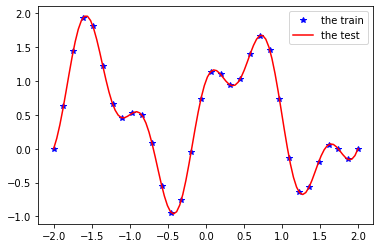

In [86]:
import numpy as np
import matplotlib.pyplot as plt

train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

print(np.shape(train_x), np.shape(train_y))
print(np.shape(test_x), np.shape(test_y))

# print(train_x)
# print(np.random.permutation(train_x.shape[1]))
# a = 0.
# print(type(a), a)

plt.figure()
plt.plot(train_x[0,:], train_y[0,:], 'b*', label = 'the train')
plt.plot(test_x[0,:], test_y[0,:], 'r-', label = 'the test')
plt.legend()
plt.show()

# STEP0: lay settings 

In [87]:
network = {}
network['L'] = 4
x_dim, y_dim = train_x.shape[0], train_y.shape[0]
network['Ns'] = [x_dim, 64, 16, y_dim]

# STEP1.1: activation function

In [88]:
def linear(z):
    return z;
def dflinear(z):
    return np.ones_like(z).astype(np.float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def dfsigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
def dftanh(z):
    return 1 - tanh(z) * tanh(z)

def relu(z):
    return z * (z > 0)
def dfrelu(z):
    return (z > 0).astype(np.float)

network['act_funcs'] = [None, tanh, tanh, linear]
network['df_act_funcs'] = [None, dftanh, dftanh, dflinear]
assert len(network['act_funcs']) == len(network[ 'df_act_funcs']), 'num'
assert len( network['act_funcs']) == network['L'], 'please set act function for each layer'

# STEP1.2: cost function

In [89]:
def mse(a, y):
    m = a.shape[1]
    return (np.sum(np.square(y-a)))/m/2
def dfmse(a, y):
    m = a.shape[1]
    return (a - y) / m

network['cost_func'] = mse
network['df_cost_func'] = dfmse

# STEP1.3: weight initialization

In [90]:
network['Ws'] = [np.random.rand(network['Ns'][l+1], network['Ns'][l]) for l in range(network['L']-1)]

for l in range(network['L']-1):
    bound = np.sqrt(6./(network['Ns'][l+1] + network['Ns'][l]))
    network['Ws'][l] = np.random.uniform(-bound, bound, (network['Ns'][l+1], network['Ns'][l]))
    print('shape of w_{} is {}'.format(l, network['Ws'][l].shape))

network['Bs'] = [np.ones((network['Ns'][l+1], 1))*0.0 for l in range(network['L']-1)]

shape of w_0 is (64, 1)
shape of w_1 is (16, 64)
shape of w_2 is (1, 16)


# STEP2.1：forward computing

In [91]:
def forward(x, network):
    m = x.shape[1]  #batch size
    z = [np.zeros((network['Ns'][l], m)) for l in range(network['L'])]
    a = [np.zeros_like(z_l) for z_l in z]

    a[0] = x;   #set input
    for l in range(0, network['L']-1):
        z[l+1] = np.dot(network['Ws'][l], a[l]) + network['Bs'][l]
        a[l+1] = network['act_funcs'][l+1](z[l+1])
        
    return a, z

# STEP2.2: backward propagation

In [92]:
def backward(y, a, z, network):
    delta = [np.zeros_like(z_l) for z_l in z]
    grad_Ws = [np.zeros_like(w_l) for w_l in network['Ws']]
    grad_Bs = [np.zeros_like(b_l) for b_l in network['Bs']]

    # set delta of last layer
    delta[-1] = network['df_cost_func'](a[-1], y) * network['df_act_funcs'][-1](z[-1])

    for l in range(network['L']-2, 0, -1):
        delta[l] = np.dot(network['Ws'][l].transpose(), delta[l+1]) * network['df_act_funcs'][l](z[l])
    
    for l in range(0, network['L']-1):
        grad_Ws[l] = np.dot(delta[l+1], a[l].transpose())
        grad_Bs[l] = delta[l+1].sum(axis = 1, keepdims = True)
    return grad_Ws, grad_Bs

gradient descent algorithm

In [93]:
def grad_decent(network, train_x, train_y, test_x, test_y, alpha=1, max_epochs=5000, batch_size=32, display_period=100):
    train_costs = []
    test_costs = []
    for k in range(max_epochs):
        sample_idxs = np.random.permutation(train_x.shape[1])   #样本编号（0~31）
        num_batch = int(np.ceil(train_x.shape[1]/batch_size))   #子集的个数
        train_cost = 0. #意味着train_cost是浮点数0.0
        for batch_idx in range(num_batch):
            x = train_x[:, sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx+1), train_x.shape[1])]] #切片，每次取一个batch
            y = train_y[:, sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx+1), train_x.shape[1])]]
            # forward computing
            a, z = forward(x, network)
            # backward computing
            train_cost = train_cost + network['cost_func'](a[-1], y) * x.shape[1]
            grad_Ws, grad_Bs = backward(y, a, z, network)
            for l in range(network['L']-1): 
                if max_epochs/5 < k < max_epochs/2:
                    alpha = 0.1
                elif k >= max_epochs/2:
                    alpha = 0.05 
                network['Ws'][l] = network['Ws'][l] - alpha * grad_Ws[l]
                network['Bs'][l] = network['Bs'][l] - alpha * grad_Bs[l]
        train_cost = train_cost / train_x.shape[1]
        if k % display_period == 0:
            train_costs.append(train_cost)
            sample_idxs = np.random.permutation(test_x.shape[1])
            num_batch = int(np.ceil(test_x.shape[1]/batch_size))
            test_cost = 0.
            for batch_idx in range(num_batch):
                test_x[:, sample_idxs[batch_size * batch_idx:min(batch_size * (batch_idx+1), test_x.shape[1])]]
                test_y[:, sample_idxs[batch_size * batch_idx:min(batch_size * (batch_idx+1), test_y.shape[1])]] 
                # forward computing
                a, z = forward(x, network)
                test_cost = test_cost + network['cost_func'](a[-1], y)*x.shape[1]
            test_cost = test_cost / test_x.shape[1]
            test_costs.append(test_cost)
            print("epoch={:6d} train_cost={:.6f}, test_cost={:.6f}".format(k, train_cost, test_cost))
    np.save('network.npy', network)
    return train_costs, test_costs


# STEP4：gradient descent algorithm

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21492\1078634804.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.ones_like(z).astype(np.float)


epoch=     0 train_cost=0.644822, test_cost=0.571516
epoch= 20000 train_cost=0.000797, test_cost=0.001020
epoch= 40000 train_cost=0.000456, test_cost=0.000584
epoch= 60000 train_cost=0.000377, test_cost=0.000482
epoch= 80000 train_cost=0.000366, test_cost=0.000468
epoch=100000 train_cost=0.000357, test_cost=0.000457
epoch=120000 train_cost=0.000353, test_cost=0.000452
epoch=140000 train_cost=0.000349, test_cost=0.000447
epoch=160000 train_cost=0.000346, test_cost=0.000443
epoch=180000 train_cost=0.000342, test_cost=0.000438


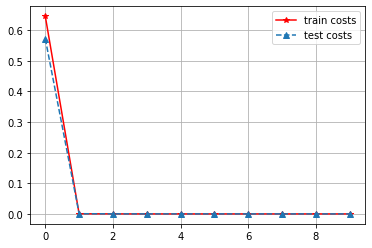

In [94]:
max_epochs = 200000
display_period = max_epochs / 10
batch_size = 32
alpha = 0.2
train_costs, test_costs = grad_decent(network, train_x, train_y, test_x, test_y, alpha, max_epochs, batch_size, display_period)
plt.figure()
plt.plot(range(len(train_costs)), train_costs, 'r-*', label='train costs') 
plt.plot(range(len(test_costs)), test_costs, '^--', label='test costs')
plt.legend()
plt.grid()
plt.show()


# STEP5：test performance

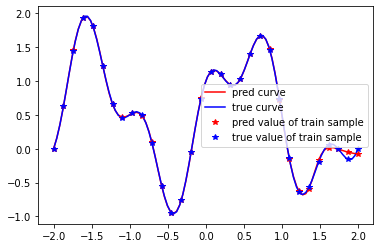

In [95]:
a, z = forward(test_x, network)
test_pred = a[-1]
plt.plot(test_x[0,:], test_pred[0,:], 'r-', label='pred curve')
plt.plot(test_x[0,:], test_y[0,:], 'b-', label='true curve')
a, z = forward(train_x, network)
train_pred = a[-1]
plt.plot(train_x[0,:], train_pred[0,:], 'r*', label='pred value of train sample')
plt.plot(train_x[0,:], train_y[0,:], 'b*', label='true value of train sample')
plt.legend()
plt.show()